**RDS (DS-UA 202) Spring 2022: Homework 2 Template**

This notebook is a template for problem 3. You should save a copy of this notebook and write your code in that copy. The code to setup the analysis is provided for you here. You should not edit or add to the setup code.

Some suggested steps are included as comments in the below code cells. You do not need to follow these (other reasonable solutions or approaches are acceptable).

# Setup

Make sure you run all cells in the setup section. Do not modify any code in this section.

In [65]:
!pip install DataSynthesizer

In [66]:
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import normalize_given_distribution, read_json_file, pairwise_attributes_mutual_information, mutual_information, set_random_seed

from IPython.display import clear_output
from scipy.stats import entropy, ks_2samp
from scipy.spatial.distance import euclidean
from sklearn.metrics import mutual_info_score
from random import randint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [67]:
def generate_data_A(input_data_file, output_data_size, seed=None):
    seed = seed or randint(0, 2**30)
    description_file = description_files['A']
    
    describer = DataDescriber()
    describer.describe_dataset_in_random_mode(input_data_file, seed=seed)
    describer.save_dataset_description_to_file(description_file)
    
    generator = DataGenerator()
    generator.generate_dataset_in_random_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

In [68]:
def generate_data_B(input_data_file, output_data_size, epsilon=0.1, seed=None):
    seed = seed or randint(0, 2**30)
    description_file = description_files['B']
    
    describer = DataDescriber()
    describer.describe_dataset_in_independent_attribute_mode(input_data_file, epsilon=epsilon, seed=seed)
    describer.save_dataset_description_to_file(description_file)
    
    generator = DataGenerator()
    generator.generate_dataset_in_independent_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

In [69]:
def generate_data_CD(input_data_file, output_data_size, description_file, epsilon=0.5, k=1, seed=None):
    seed = seed or randint(0, 2**30)
    
    describer = DataDescriber()
    describer.describe_dataset_in_correlated_attribute_mode(input_data_file, k=k, epsilon=epsilon, seed=seed)
    describer.save_dataset_description_to_file(description_file)
    
    generator = DataGenerator()
    generator.generate_dataset_in_correlated_attribute_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

def generate_data_C(input_data_file, output_data_size, epsilon=0.1, seed=None):
    return generate_data_CD(input_data_file, output_data_size, description_files['C'], epsilon, k=1, seed=seed)

def generate_data_D(input_data_file, output_data_size, epsilon=0.1, seed=None):
    return generate_data_CD(input_data_file, output_data_size, description_files['D'], epsilon, k=2, seed=seed)

Start with a real dataset __hw_compas__ and a fake dataset __hw_fake__. Generate synthetic datasets of size __N=10000__, in the following four categories:
- A:  random mode
- B: independent attribute mode with __epsilon = 0.1__
- C:  correlated attribute mode with __epsilon = 0.1__, Bayes net degree k=1
- D: correlated attribute mode with __epsilon = 0.1__, Bayes net degree k=2

In [70]:
# Packages for reading csv file into Colaboratory:
!pip install -U -q PyDrive==1.3.1

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client. 
# Please follow the steps as instructed when you run the following commands. 

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [71]:
fileid_compas = '1kgSIBkOM9y0nz_l8LI8ze9TAhF5gbb64'    
real_data_file = 'hw_compas.csv'

fileid_fake = '1b_T0SHQUMbVvZueZ6yXlxTKBHctMgM0k'    
fake_data_file = 'hw_fake.csv'

downloaded = drive.CreateFile({'id':fileid_compas}) 
downloaded.GetContentFile(real_data_file)  
df_real = pd.read_csv(real_data_file)

downloaded = drive.CreateFile({'id':fileid_fake}) 
downloaded.GetContentFile(fake_data_file)  
df_fake = pd.read_csv(fake_data_file)

In [72]:
output_data_size = 10000
epsilon = 0.1

seed = 0  # make the entire notebook reproducible

description_files = {'A': './descrption_A.json', 
                     'B': './descrption_B.json', 
                     'C': './descrption_C.json', 
                     'D': './descrption_D.json'}

set_random_seed(seed)

df_real_A = generate_data_A(real_data_file, output_data_size)
df_real_B = generate_data_B(real_data_file, output_data_size, epsilon=epsilon)
df_real_C = generate_data_C(real_data_file, output_data_size, epsilon=epsilon)
df_real_D = generate_data_D(real_data_file, output_data_size, epsilon=epsilon)

df_fake_A = generate_data_A(fake_data_file, output_data_size)
df_fake_B = generate_data_B(fake_data_file, output_data_size, epsilon=epsilon)
df_fake_C = generate_data_C(fake_data_file, output_data_size, epsilon=epsilon)
df_fake_D = generate_data_D(fake_data_file, output_data_size, epsilon=epsilon)

clear_output()

## Q1

Calculate the Median, Mean, Min, Max of __age__ and __score__ for each A, B, C and D. Compare to the ground truth values in __hw_compas__, present results in a table.

In [73]:
#install tabulate so i can make a table
!pip install tabulate
from tabulate import tabulate

In [74]:
data =  [
        ["Ground Truth","Age",df_real["age"].median(),df_real["age"].mean(),df_real["age"].min(),df_real["age"].max()],
        [" ","Score",df_real["score"].median(),df_real["score"].mean(),df_real["score"].min(),df_real["score"].max()],
        [" "],
        ["A","Age",df_real_A["age"].median(),df_real_A["age"].mean(),df_real_A["age"].min(),df_real_A["age"].max()],
        [" ","Score",df_real_A["score"].median(),df_real_A["score"].mean(),df_real_A["score"].min(),df_real_A["score"].max()],
        [" "],
        ["B","Age",df_real_B["age"].median(),df_real_B["age"].mean(),df_real_B["age"].min(),df_real_B["age"].max()],
        [" ","Score",df_real_B["score"].median(),df_real_B["score"].mean(),df_real_B["score"].min(),df_real_B["score"].max()],
        [" "],
        ["C","Age",df_real_C["age"].median(),df_real_C["age"].mean(),df_real_C["age"].min(),df_real_C["age"].max()],
        [" ","Score",df_real_C["score"].median(),df_real_C["score"].mean(),df_real_C["score"].min(),df_real_C["score"].max()],
        [" "],
        ["D","Age",df_real_D["age"].median(),df_real_D["age"].mean(),df_real_D["age"].min(),df_real_D["age"].max()],
        [" ","Score",df_real_D["score"].median(),df_real_D["score"].mean(),df_real_D["score"].min(),df_real_D["score"].max()],
        ]
        
headers = ["Data","Column","Median","Mean","Min","Max"]
print(tabulate(data, headers=headers))

Data          Column      Median      Mean    Min    Max
------------  --------  --------  --------  -----  -----
Ground Truth  Age             32  35.1433      18     96
              Score            4   4.37127     -1     10

A             Age             51  50.1731       0    100
              Score            5   4.9392      -1     10

B             Age             33  35.7354      18     76
              Score            4   4.3657       1     10

C             Age             36  41.5788      18     96
              Score            5   4.9487      -1     10

D             Age             39  44.1532      18     96
              Score            4   4.466       -1     10


## Q2

Plot histograms of the age attribute in hw_compas and in synthetic datasets generated under settings A and B.

Text(0.5, 1.0, 'Independent Attribute Mode')

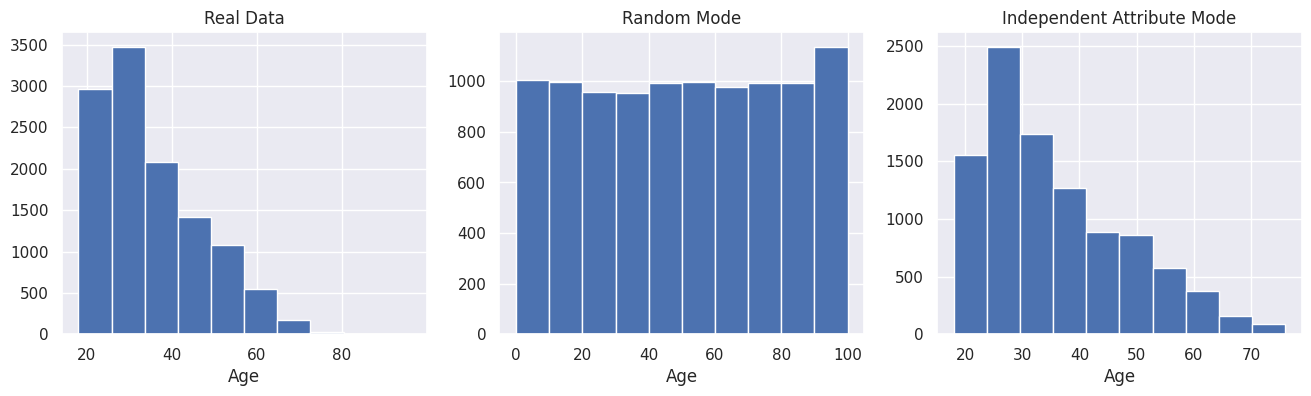

In [75]:
figs,axes = plt.subplots(1,3,figsize=(16,4),dpi=100)

axes[0].hist(df_real["age"])
axes[0].set_xlabel('Age')
axes[0].set_title('Real Data')

axes[1].hist(df_real_A["age"])
axes[1].set_xlabel('Age')
axes[1].set_title('Random Mode')

axes[2].hist(df_real_B["age"])
axes[2].set_xlabel('Age')
axes[2].set_title('Independent Attribute Mode')

Create bar plots for the sex attribute in hw_compas and in synthetic datasets generated under settings A and B.

Text(0.5, 1.0, 'Independent Attribute Mode')

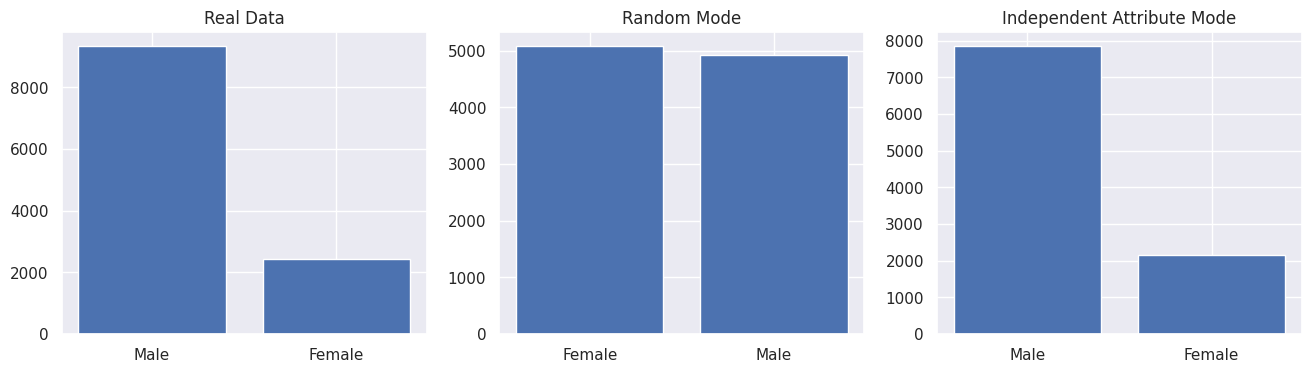

In [76]:
figs,axes = plt.subplots(1,3,figsize=(16,4),dpi=100)

axes[0].bar(df_real["sex"].unique(), df_real["sex"].value_counts())
axes[0].set_title('Real Data')

axes[1].bar(df_real_A["sex"].unique(), df_real_A["sex"].value_counts())
axes[1].set_title('Random Mode')

axes[2].bar(df_real_B["sex"].unique(), df_real_B["sex"].value_counts())
axes[2].set_title('Independent Attribute Mode')


The functions below can be used to compute two statistical measures: __Two-sample Kolmogorov–Smirnov test__ and __KL-divergence__.

### Two-sample Kolmogorov–Smirnov test for continuous attributes

Use the `ks_test` function to run the Kolomogorov-Smirnov test on the age attribute. You should first test `df_real` against `df_real_A` and then test `df_real` against `df_real_B`.

In [77]:
def ks_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for Two-sample Kolmogorov–Smirnov test
    """
    return ks_2samp(df_in[attr], df_out[attr])[0]

In [78]:
# Your code here
ksTest1 = ks_test(df_real, df_real_A, "age")
print(ksTest1)

ksTest2 = ks_test(df_real, df_real_B, "age")
print(ksTest2)

0.3735091775112699
0.026252445351705345


### KL-divergence for categorical attributes

Use the `kl_test` function to calculate the KL-divergence on the sex attribute. You should first run `df_real` against `df_real_A` and then run `df_real` against `df_real_B`.

In [79]:
def get_distribution_of_categorical_attribute(attribute: pd.Series, indicies=None):
    distribution = attribute.dropna().value_counts()
    if indicies is not None:
        for idx in set(indicies) - set(distribution.index):
            distribution.loc[idx] = 0
    distribution.sort_index(inplace=True)
    return distribution/sum(distribution)

def kl_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for KL-divergence.
    """
    distribution_in = get_distribution_of_categorical_attribute(df_in[attr])
    distribution_out = get_distribution_of_categorical_attribute(df_out[attr], distribution_in.index)
    return entropy(distribution_out, distribution_in)

In [80]:
# Your code here
klTest1 = kl_test(df_real, df_real_A, "sex")
print(klTest1)

klTest2 = kl_test(df_real, df_real_B, "sex")
print(klTest2)

0.22319792405369002
0.0002494300869420041


## Q3

Calculate the pairwise mutual information matrix for `df_fake`, `df_fake_C`, and `df_fake_D`.

In [81]:
# Use pairwise_attributes_mutual_information function
# For function parameters, refer to https://github.com/DataResponsibly/DataSynthesizer/blob/master/DataSynthesizer/lib/utils.py#L31
pairwise_fake = pairwise_attributes_mutual_information(df_fake)
pairwise_fake_C = pairwise_attributes_mutual_information(df_fake_C)
pairwise_fake_D = pairwise_attributes_mutual_information(df_fake_D)
print("Fake Data Set Pairwise Mutual Information Matrix")
print(pairwise_fake)
print("\nCorrelated Attribute Mode Pairwise Mutual Information Matrix (k=1)")
print(pairwise_fake_C)
print("\nCorrelated Attribute Mode Pairwise Mutual Information Matrix (k=2)")
print(pairwise_fake_D)

Fake Data Set Pairwise Mutual Information Matrix
           child_1   child_2  parent_1  parent_2
child_1   1.000000  0.211242  0.214345  0.195899
child_2   0.211242  1.000000  0.208301  0.200690
parent_1  0.214345  0.208301  1.000000  0.002421
parent_2  0.195899  0.200690  0.002421  1.000000

Correlated Attribute Mode Pairwise Mutual Information Matrix (k=1)
           child_1   child_2  parent_1  parent_2
child_1   1.000000  0.229400  0.070395  0.026739
child_2   0.229400  1.000000  0.249762  0.114695
parent_1  0.070395  0.249762  1.000000  0.028520
parent_2  0.026739  0.114695  0.028520  1.000000

Correlated Attribute Mode Pairwise Mutual Information Matrix (k=2)
           child_1   child_2  parent_1  parent_2
child_1   1.000000  0.074153  0.034209  0.221418
child_2   0.074153  1.000000  0.203135  0.110479
parent_1  0.034209  0.203135  1.000000  0.073704
parent_2  0.221418  0.110479  0.073704  1.000000


Plot each pairwise mutual information matrix below using `sns.heatmap`. You should set `vmax=1` and `vmin=0` in your call to `sns.heatmap`.

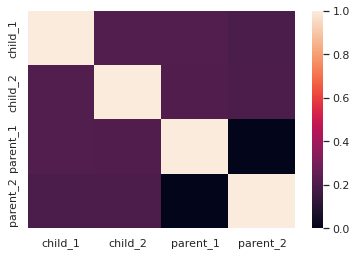

In [82]:
# Use can sns.heatmap for pairwise mutual information
# For examples, refer to https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(pairwise_fake,vmin=0,vmax=1)

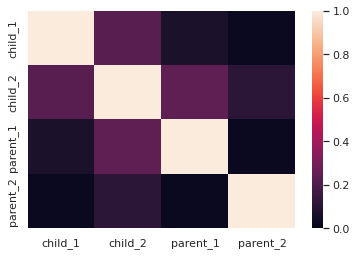

In [83]:
sns.heatmap(pairwise_fake_C,vmin=0,vmax=1)

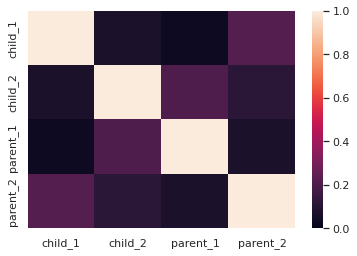

In [84]:
sns.heatmap(pairwise_fake_D,vmin=0,vmax=1)

# Part (b)

With epsilon = 0.1, generate __10__ synthetic datasets for each of mode A, B, and C by specifying different seeds. (You should generate 30 datasets in total: 10 for setting A, 10 for setting B, 10 for setting C). Calculate the mean and median in each dataset. We recommend using a for loop here, e.g. `for rep in range(10):`

In [85]:
set_random_seed(seed) # this will specify different seeds
data = []
for rep in range(10):
  temp_A = []
  temp_B = []
  temp_C = []
  print("\nrep:", rep+1)
  synthetic_A = generate_data_A(real_data_file,output_data_size,seed=seed)
  temp_A.append("A")
  temp_A.append(synthetic_A["age"].mean())
  temp_A.append(synthetic_A["age"].median())
  print("Random Mode Mean:", synthetic_A["age"].mean())
  print("Random Mode Median:", synthetic_A["age"].median())
  synthetic_B = generate_data_B(real_data_file,output_data_size,epsilon=0.1,seed=seed)
  temp_B.append("B")
  temp_B.append(synthetic_B["age"].mean())
  temp_B.append(synthetic_B["age"].median())
  print("Independent Attribute Mode Mean:", synthetic_B["age"].mean())
  print("Independent Attribute Mode Median:", synthetic_B["age"].median())
  synthetic_C = generate_data_C(real_data_file,output_data_size,epsilon=0.1,seed=seed)
  temp_C.append("C")
  temp_C.append(synthetic_C["age"].mean())
  temp_C.append(synthetic_C["age"].median())
  print("Correlated Attribute Mode Mean:", synthetic_C["age"].mean())
  print("Correlated Attribute Mode Median:", synthetic_C["age"].median())
  data.append(temp_A)
  data.append(temp_B)
  data.append(temp_C)



rep: 1
Random Mode Mean: 50.1731
Random Mode Median: 51.0
Independent Attribute Mode Mean: 35.7354
Independent Attribute Mode Median: 33.0
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
Correlated Attribute Mode Mean: 41.5788
Correlated Attribute Mode Median: 36.0

rep: 2
Random Mode Mean: 49.8201
Random Mode Median: 49.0
Independent Attribute Mode Mean: 36.9584
Independent Attribute Mode Median: 33.0
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
Correlated Attribute Mode Mean: 44.039
Correlated Attribute Mode Median: 38.0

rep: 3
Random Mode Mean: 50.638
Random Mode Median: 51.0
Independent Attribute Mode Mean: 36.0901
Independent Attribute Mo

In [86]:
df = pd.DataFrame(data)
df.columns = ["Mode","Mean","Median"]

Plot the mean and the median values as box-and-whiskers plots. You should have two plots: one for the mean and one for the median. Put the mode (A, B, C) on the x-axis. The median/mean should be on the y-axis.

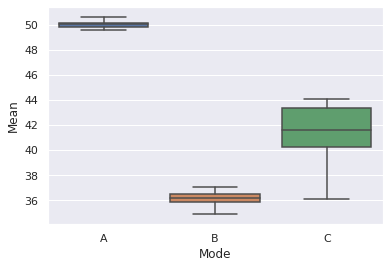

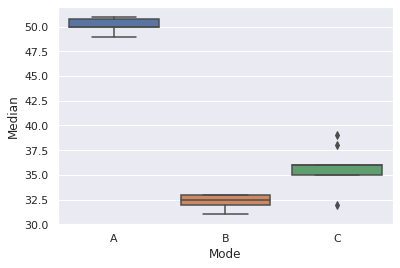

In [87]:
# You can use sns.boxplot for the plots
# For examples, refer to https://seaborn.pydata.org/generated/seaborn.boxplot.html
sns.boxplot(x="Mode",y="Mean",data=df)
plt.show()

sns.boxplot(x="Mode",y="Median",data=df)
plt.show()

# Part (c)

Study how the KL-divergence of the race attribute changes for settings B, C, and D as you vary your privacy budget __epsilon__ = [0.02, 0.04, ... , 0.1]. For each setting B, C, D, you should generate 10 synthetic data sets for each epsilon value (a total of 3 * 10 * 5 = 150 datasets). 

Hint: We recommend using a nested for loop and have provided some starter code in the cell below. You may use a different approach as you see fit.

In [88]:
# generate the datasets and calculate KL-divergence in this cell
set_random_seed(seed)
epsilons = [0.02, 0.04, 0.06, 0.08, 0.1]
repeat = 10
arr_B = []
arr_C = [] 
arr_D = []
for i, epsilon in enumerate(epsilons):
  print(f'~~~ i={i}, epsilon={epsilon} ~~~')
  for rep in range(repeat):
    temp_B = []
    temp_C = []
    temp_D = []
    synthetic_B = generate_data_B(real_data_file,output_data_size, epsilon=epsilon,seed=seed)
    temp_B.append(epsilon)
    temp_B.append(kl_test(df_real, synthetic_B, "race"))
    synthetic_C = generate_data_C(real_data_file,output_data_size, epsilon=epsilon,seed=seed)
    temp_C.append(epsilon)
    temp_C.append(kl_test(df_real, synthetic_C, "race"))
    synthetic_D = generate_data_D(real_data_file,output_data_size, epsilon=epsilon,seed=seed)
    temp_D.append(epsilon)
    temp_D.append(kl_test(df_real, synthetic_D, "race"))
    arr_B.append(temp_B)
    arr_C.append(temp_C)
    arr_D.append(temp_D)

~~~ i=0, epsilon=0.02 ~~~
================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute race
Adding attribute score
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute age
Adding attribute sex
Adding attribute score
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute race
Adding attribute score
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute score
Adding attribute age
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding a

Create the box-and-whisker plots in the cell below.

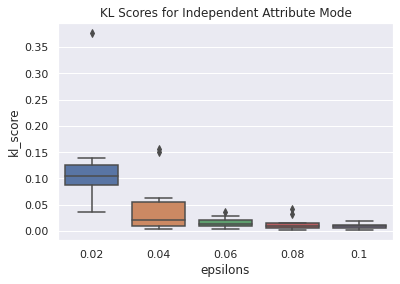

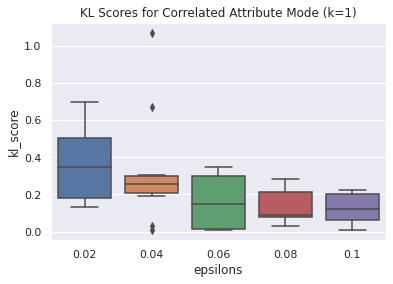

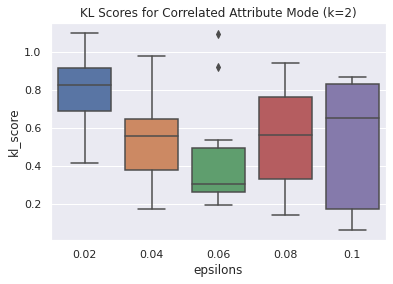

In [89]:
kl_b = pd.DataFrame(arr_B)
kl_b.columns = ["epsilons", "kl_score"]

kl_c = pd.DataFrame(arr_C)
kl_c.columns = ["epsilons", "kl_score"]

kl_d = pd.DataFrame(arr_D)
kl_d.columns = ["epsilons", "kl_score"]

(sns.boxplot(x="epsilons",y="kl_score",data=kl_b))
plt.title("KL Scores for Independent Attribute Mode")
plt.show()

(sns.boxplot(x="epsilons",y="kl_score",data=kl_c))
plt.title("KL Scores for Correlated Attribute Mode (k=1)")
plt.show()

(sns.boxplot(x="epsilons",y="kl_score",data=kl_d))
plt.title("KL Scores for Correlated Attribute Mode (k=2)")
plt.show()